<a href="https://colab.research.google.com/github/elianderlohr/muse-dlf/blob/main/notebooks/explainablity/muse-dlf-explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MuSE-DLF Explainability

Plot the explainability of the MuSE-DLF model. By using the dictionary learning approach it is (1.) possible to extract how different words in a certaim semantic role predict the presence of a document level frame and (2.) identify how the FrameAxis constallations are predicting the document level frames.

In [1]:
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/Git/muse-dlf

assets		       category_lists_p.pkl  predicted_labels.npy  src		used_labels_a0.npy
category_lists_a0.pkl  data		     README.md		   tests	used_labels_a1.npy
category_lists_a1.pkl  model.md		     research-notebooks    ToDo.md	used_labels_p.npy
category_lists_fx.pkl  notebooks	     run		   used_fx.npy


In [4]:
!pip install wandb==0.17.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.4 MB/s eta 0:00:00


In [4]:
!pip install allennlp allennlp-models

  Using cached wandb-0.12.21-py2.py3-none-any.whl.metadata (7.2 kB)
  Using cached huggingface_hub-0.10.1-py3-none-any.whl.metadata (6.1 kB)
Using cached huggingface_hub-0.10.1-py3-none-any.whl (163 kB)
Using cached wandb-0.12.21-py2.py3-none-any.whl (1.8 MB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.5
    Uninstalling huggingface-hub-0.24.5:
      Successfully uninstalled huggingface-hub-0.24.5
  Attempting uninstall: wandb
    Found existing installation: wandb 0.17.4
    Uninstalling wandb-0.17.4:
      Successfully uninstalled wandb-0.17.4


In [5]:
!pip install torch==2.3.1

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [6]:
!pip install iterative-stratification

In [7]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 43.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 39.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


In [9]:
import sys
sys.path.append('/content/drive/MyDrive/Git/muse-dlf/src')

In [10]:
from preprocessing.pre_processor import PreProcessor
from preprocessing.datasets.article_dataset import custom_collate_fn
from model.muse_dlf.muse import MuSEDLF
from model.slmuse_dlf.muse import SLMuSEDLF

# import tokenizer for roberta fast
from transformers import RobertaTokenizerFast
import wandb
import inspect
import torch
import spacy
import pickle
from pathlib import Path
from torch.utils.data import DataLoader

In [11]:
wandb.require("core")

In [12]:
import nltk

In [13]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
base_path = "drive/MyDrive/Git/"

## Setup wandb

In [16]:
from google.colab import userdata

wandb.login(key=userdata.get('WANDB_API_KEY'))

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
run = wandb.init(project="muse-dlf", job_type="inference")

wandb: Currently logged in as: elias-anderlohr (elianderlohr). Use `wandb login --relogin` to force relogin


## Clean

In [18]:
def clean_gpu_memory():
    # Clear cache
    torch.cuda.empty_cache()
    # Reset peak memory stats
    torch.cuda.reset_peak_memory_stats()
    # Perform garbage collection
    import gc
    gc.collect()

clean_gpu_memory()

## Load MuSE-DLF

## Load Roberta Model

In [18]:
roberta_artifact = run.use_artifact('elianderlohr-org/wandb-registry-model/semeval-roberta-finetune:latest', type='model')
roberta_dir = roberta_artifact.download()

wandb: Downloading large artifact semeval-roberta-finetune:latest, 1427.27MB. 7 files... 
Done. 0:0:0.1


In [19]:
!ls /content/artifacts/roberta-base-finetune-checkpoint-16482:v0

config.json	   optimizer.pt     scheduler.pt	training_args.bin
model.safetensors  rng_state_0.pth  trainer_state.json


## Load Datasets

### Load Dev Dataset

In [ ]:
dataset_dev_artifact = run.use_artifact('elianderlohr-org/wandb-registry-dataset/semeval-dev:latest', type='dataset')
dataset_dev_dir = dataset_dev_artifact.download()

### Load Train Dataset

In [20]:
dataset_train_artifact = run.use_artifact('elianderlohr-org/wandb-registry-dataset/semeval-train:latest', type='dataset')
dataset_train_dir = dataset_train_artifact.download()

### Load Test Dataset

In [21]:
dataset_test_artifact = run.use_artifact('elianderlohr-org/wandb-registry-dataset/semeval-test:latest', type='dataset')
dataset_test_dir = dataset_test_artifact.download()

## Load Model

In [22]:
import inspect
def load_model_from_wandb(name):
    model_artifact = run.use_artifact(name, type='model')
    model_dir = model_artifact.download()

    # Access the configuration
    config = model_artifact.metadata
    # Get the parameters of the SLMUSEDLF class constructor
    params = inspect.signature(MuSEDLF.__init__).parameters

    # Extract the relevant parameters from the config dictionary
    model_params = {key: config[key] for key in params if key in config}
    model_params["bert_model_name"] = "roberta-base"
    model_params["bert_model_name_or_path"] = roberta_dir
    # model_params["_debug"] = True

    model = MuSEDLF(**model_params)
    model.set_log_level("INFO")

    # Assuming you load the state_dict as follows
    state_dict = torch.load(f"{model_dir}/pytorch_model.bin", map_location="cuda")
    model.load_state_dict(state_dict)

    return model, config

# name = 'elianderlohr/muse-dlf/eval_flaring_watch_2603_model:v0' --> best
# name = 'elianderlohr/muse-dlf/eval_spinning_umbrella_3887_model:v6'
name = 'elianderlohr/muse-dlf/eval_burning_helmet_8544_model:v0'
#model, config = load_model_from_wandb(name)

In [23]:
model_name = name.split("/")[2].replace(":", "-")
model_name

'eval_burning_helmet_8544_model-v0'

## Create Dataset

In [24]:
!ls drive/MyDrive/Git/muse-dlf/data/axis

732_semaxis_axes.tsv  mft_experiment.json  mft_raw.csv
custom.tsv	      mft_filtered.csv	   plutchik_wheel_of_emotions.tsv
frames.json	      mft.json		   wordnet_antonyms.tsv


In [25]:
class_column_names = "Capacity_and_resources;Crime_and_punishment;Cultural_identity;Economic;External_regulation_and_reputation;Fairness_and_equality;Health_and_safety;Legality_Constitutionality_and_jurisprudence;Morality;Policy_prescription_and_evaluation;Political;Public_opinion;Quality_of_life;Security_and_defense".split(";")

### Create Full Dataset

### Create Dev Dataset

In [ ]:
# Define paths to the dataset files within the downloaded directory
dev_artifact_filepath = Path(dataset_dev_dir) / 'dataset_artifact.pkl'

# Load the datasets from the artifact files
with dev_artifact_filepath.open("rb") as f:
    loaded_dev_dataset = pickle.load(f)

In [ ]:
dev_dataset = loaded_dev_dataset

In [ ]:
dev_dataloader = DataLoader(
    dev_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=custom_collate_fn,
    drop_last=False,
    pin_memory=True,
    num_workers=1,
)

### Create Train Dataset

In [26]:
# Define paths to the dataset files within the downloaded directory
train_artifact_filepath = Path(dataset_train_dir) / 'dataset_artifact.pkl'

# Load the datasets from the artifact files
with train_artifact_filepath.open("rb") as f:
    loaded_train_dataset = pickle.load(f)

In [27]:
train_dataset = loaded_train_dataset

In [28]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=custom_collate_fn,
    drop_last=False,
    pin_memory=True,
    num_workers=1,
)

### Create Test Dataset

In [29]:
# Define paths to the dataset files within the downloaded directory
test_artifact_filepath = Path(dataset_test_dir) / 'dataset_artifact.pkl'

# Load the datasets from the artifact files
with test_artifact_filepath.open("rb") as f:
    loaded_test_dataset = pickle.load(f)

In [30]:
test_dataset, test_df = loaded_test_dataset

In [31]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=custom_collate_fn,
    drop_last=False,
    pin_memory=True,
    num_workers=1,
)

### Create Example Dataset

In [16]:
preprocessor = PreProcessor(
    tokenizer=tokenizer,
    batch_size=32,
    max_sentences_per_article=config["num_sentences"],
    max_sentence_length=config["max_sentence_length"],
    max_args_per_sentence=config["max_args_per_sentence"],
    max_arg_length=config["max_arg_length"],
    frameaxis_dim=config["frameaxis_dim"],
    bert_model_name="roberta-base",
    name_tokenizer="roberta-base",
    path_name_bert_model=roberta_dir,
    path_antonym_pairs=f"{base_path}muse-dlf/data/axis/mft.json",
    dim_names=["virtue", "vice"],
    class_column_names=class_column_names,
    )

NameError: name 'config' is not defined

In [26]:
text = "Journalist names obstacle to peace between Ukraine and Russia The Ukrainian leader is “dangerous” as he’s ready to sacrifice his people to stay in power, Angelo D’Orsi claims Ukrainian President Volodymyr Zelensky is the main obstacle to peace between his country and Russia, renowned Italian journalist and historian Angelo D'Orsi has told RT. D’Orsi has been left disappointed by the coverage of the Ukrainian conflict in the Western media, including in his home country of Italy. In March, he refused to continue cooperating with major newspaper La Stampa after it used a photo of the aftermath of a missile attack on Donetsk by the Kiev forces to illustrate a headlining article bout about Russian strikes in western Ukraine. The paper has reached “the bottom of journalistic dishonesty” with this move, D’Orsi insisted in one of the interviews. The veteran journalist rejects attempts to portray Zelensky as a hero, warning that the Ukrainian leader is actually “a very dangerous character.” “In my opinion, Zelensky now represents the biggest obstacle to achieving peace because it seems obvious to me that he’s is ready to sacrifice his country and his people in order to stay in power,” D’Orsi said. The Ukrainian president is “absolutely preventing any diplomatic solution, any peace talks. And he’s proven it many times,” he added. Russian and Ukrainian delegations of various levels have held several rounds of peace negotiations since the outbreak of the fighting. But there have been no face-to-face meetings since late March, when the sides met in Istanbul, Turkey, although Russia says the talks continue every day via videolink. Moscow was initially optimistic about the outcome of the Istanbul talks, but later blamed Kiev for backtracking on the agreements that had been reached there. On Wednesday, Russia’s Foreign Ministry spokeswoman Maria Zakharova said that Moscow has lost all trust in Ukrainian negotiators, adding that it was the reason why the differences between the neighbors kept being settled on the ground. On April 16, Zelensky issued an ultimatum to Russia: the President of Ukraine said that if Russian troops destroyed the Ukrainian military remaining in Mariupol, then there would be no negotiations. On April 21, Russia decided against storming the town’s Azovstal steel plant, where the Ukrainian troops are besieged. Moscow declared Mariupol ‘liberated.’ On the same day, Zelensky said he does not rule out that the de-blockading of Mariupol could happen by military means. Zelensky “acts as if this confrontation was a personal conflict between [Russia’s President Vladimir] Putin and him” without actually caring about Ukraine, D’Orsi insisted. The comedian-turned-president “seems totally clueless to me, not fit to cope with such a situation,” he added. Zelensky’s “frantic activeness,” which includes filming numerous videos and delivering video addresses with demands for help before lawmakers in the US, EU and elsewhere, “could eventually backfire against him,” the journalist warned. The Ukrainian leader has been asking the West for weapons deliveries, financial and humanitarian aid, increased sanctions pressure on Russia, and EU membership for his country. However, many of his requests remain unfulfilled, including a demand to close Ukraine’s skies to Russian planes, which is almost certain to provoke a conflict between Moscow and NATO. D’Orsi also insisted that use of the word “genocide” by Zelensky to describe the events in Ukraine was “unacceptable.” He is Jewish, but the Ukrainian leader “shouldn’t forget that neo-Nazis are now supporting his government,” he said. “It’s really a paradox when one speaks about genocide to justify one’s own policies, forgetting that he’s backed by the descendants of the very people who persecuted the Jews in the 1930s and 1940s,” the journalist pointed out. Russia attacked the neighboring state in late February, following Ukraine’s failure to implement the terms of the Minsk agreements, first signed in 2014, and Moscow’s eventual recognition of the Donbass republics of Donetsk and Lugansk. The German and French brokered protocols were designed to give the breakaway regions special status within the Ukrainian state. The Kremlin has since demanded that Ukraine officially declare itself a neutral country that will never join the US-led NATO military bloc. Kiev insists the Russian offensive was completely unprovoked and has denied claims it was planning to retake the two republics by force. "

In [27]:
example_dataset, example_dataloader = preprocessor.preprocess_single_article(
    text
)

INFO:preprocessing.srl_processor:Recalculating SRL components...


ModuleNotFoundError: No module named 'allennlp'

## Run model with data

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import torch

def predict_inspect(model, dataloader, device='cuda', return_labels=False):
    """
    Make predictions with the given model and dataloader.

    Args:
    - model (torch.nn.Module): The model to make predictions with.
    - dataloader (DataLoader): DataLoader for the dataset to predict on.
    - device (str): Device to make predictions on ('cpu' or 'cuda').

    Returns:
    - predicted_labels (list of lists): List containing the predicted labels for each instance.
    - Various arrays containing the 'd' and 'g' parameters for predicate, arg0, arg1, and fx.
    """
    model = model.to("cuda")
    model.eval()

    # dim
    batch_size = dataloader.batch_size
    num_sentences = dataloader.dataset.max_sentences_per_article
    max_args_per_sentence = dataloader.dataset.max_args_per_sentence
    K = 14

    print("num_batches", len(dataloader))
    print("batch_size", batch_size)
    print("num_sentences", num_sentences)
    print("max_args_per_sentence", max_args_per_sentence)
    print("K", K)

    all_preds_span = []

    all_labels = []

    # Initialize usage lists for each label
    all_used_labels_p_d = []
    all_used_labels_p_g = []
    all_used_labels_a0_d = []
    all_used_labels_a0_g = []
    all_used_labels_a1_d = []
    all_used_labels_a1_g = []

    all_used_fx_d = []
    all_used_fx_g = []

    with torch.no_grad():
        # Wrap the dataloader with tqdm for batch progress
        for batch in tqdm(dataloader, desc="Processing Batches"):
            sentence_ids = batch['sentence_ids'].to(device)
            sentence_attention_masks = batch['sentence_attention_masks'].to(device)

            predicate_ids = batch['predicate_ids'].to(device)
            arg0_ids = batch['arg0_ids'].to(device)
            arg1_ids = batch['arg1_ids'].to(device)

            frameaxis_data = batch['frameaxis'].to(device)

            if return_labels:
              labels = batch['labels']

            sentence_embeddings, predicate_embeddings, arg0_embeddings, arg1_embeddings = model.aggregation(sentence_ids, sentence_attention_masks, predicate_ids, arg0_ids, arg1_ids)

            # Process each span
            for sentence_idx in range(sentence_embeddings.size(1)):
                s_sentence_span = sentence_embeddings[:, sentence_idx, :]
                v_fx = frameaxis_data[:, sentence_idx, :]

                for span_idx in range(predicate_embeddings.size(2)):
                    v_p_span = predicate_embeddings[:, sentence_idx, span_idx, :]
                    v_a0_span = arg0_embeddings[:, sentence_idx, span_idx, :]
                    v_a1_span = arg1_embeddings[:, sentence_idx, span_idx, :]

                    mask_p = (v_p_span.abs().sum(dim=-1) != 0).float().bool()
                    mask_a0 = (v_a0_span.abs().sum(dim=-1) != 0).float().bool()
                    mask_a1 = (v_a1_span.abs().sum(dim=-1) != 0).float().bool()

                    output = model.unsupervised.combined_autoencoder(
                        v_p_span, v_a0_span, v_a1_span, mask_p, mask_a0, mask_a1, s_sentence_span, 0.6
                    )

                    all_used_labels_p_d.append(output["p"]["d"].cpu().numpy())
                    all_used_labels_p_g.append(output["p"]["g"].cpu().numpy())
                    all_used_labels_a0_d.append(output["a0"]["d"].cpu().numpy())
                    all_used_labels_a0_g.append(output["a0"]["g"].cpu().numpy())
                    all_used_labels_a1_d.append(output["a1"]["d"].cpu().numpy())
                    all_used_labels_a1_g.append(output["a1"]["g"].cpu().numpy())

                    del v_p_span, v_a0_span, v_a1_span, mask_p, mask_a0, mask_a1, output
                    torch.cuda.empty_cache()

                mask_fx = (v_fx.abs().sum(dim=-1) != 0).float().bool()

                frameaxis_output = model.unsupervised_fx.frameaxis_autoencoder(v_fx, mask_fx, s_sentence_span, 0.6)

                all_used_fx_d.append(frameaxis_output["d"].cpu().numpy())
                all_used_fx_g.append(frameaxis_output["g"].cpu().numpy())

                del v_fx, mask_fx, frameaxis_output
                torch.cuda.empty_cache()

            # Forward pass
            outputs = model(
                sentence_ids, sentence_attention_masks, predicate_ids, arg0_ids, arg1_ids, frameaxis_data, 0.5
            )

            supervised_logits = outputs["supervised_logits"]

            combined_pred = (torch.sigmoid(supervised_logits) > 0.5).long()

            all_preds_span.append(combined_pred.cpu().numpy())

            if return_labels:
              all_labels.append(labels)

            del sentence_ids, sentence_attention_masks, predicate_ids, arg0_ids, arg1_ids, frameaxis_data
            del sentence_embeddings, predicate_embeddings, arg0_embeddings, arg1_embeddings
            del supervised_logits, combined_pred
            torch.cuda.empty_cache()

    predictions = np.vstack(all_preds_span)

    all_used_labels_p_d = np.vstack(all_used_labels_p_d)
    all_used_labels_p_g = np.vstack(all_used_labels_p_g)
    all_used_labels_a0_d = np.vstack(all_used_labels_a0_d)
    all_used_labels_a0_g = np.vstack(all_used_labels_a0_g)
    all_used_labels_a1_d = np.vstack(all_used_labels_a1_d)
    all_used_labels_a1_g = np.vstack(all_used_labels_a1_g)

    all_used_fx_d = np.vstack(all_used_fx_d)
    all_used_fx_g = np.vstack(all_used_fx_g)

    all_used_labels_p_d = all_used_labels_p_d.reshape(-1, num_sentences, max_args_per_sentence, K)
    all_used_labels_p_g = all_used_labels_p_g.reshape(-1, num_sentences, max_args_per_sentence, K)
    all_used_labels_a0_d = all_used_labels_a0_d.reshape(-1, num_sentences, max_args_per_sentence, K)
    all_used_labels_a0_g = all_used_labels_a0_g.reshape(-1, num_sentences, max_args_per_sentence, K)
    all_used_labels_a1_d = all_used_labels_a1_d.reshape(-1, num_sentences, max_args_per_sentence, K)
    all_used_labels_a1_g = all_used_labels_a1_g.reshape(-1, num_sentences, max_args_per_sentence, K)

    all_used_fx_d = all_used_fx_d.reshape(-1, num_sentences, K)
    all_used_fx_g = all_used_fx_g.reshape(-1, num_sentences, K)


    if return_labels:
      all_labels = np.vstack(labels)
      return predictions, all_labels, all_used_labels_p_d, all_used_labels_p_g, all_used_labels_a0_d, all_used_labels_a0_g, all_used_labels_a1_d, all_used_labels_a1_g, all_used_fx_d, all_used_fx_g
    else:
      return predictions, all_used_labels_p_d, all_used_labels_p_g, all_used_labels_a0_d, all_used_labels_a0_g, all_used_labels_a1_d, all_used_labels_a1_g, all_used_fx_d, all_used_fx_g

In [ ]:
all_labels = np.vstack(labels_list)

In [ ]:
clean_gpu_memory()

In [28]:
env = "train"

In [ ]:
env = "train"

output = predict_inspect(model, train_dataloader, device="cuda", return_labels=False)

(predicted_labels,
  used_labels_p_d, used_labels_p_g,
  used_labels_a0_d, used_labels_a0_g,
  used_labels_a1_d, used_labels_a1_g,
  used_fx_d, used_fx_g) = output

np.savez(base_path + f'/muse-dlf/data/explainability/semeval/output_{model_name}_{env}_muse-dlf-model.npz',
         predicted_labels=predicted_labels,
         used_labels_p_d=used_labels_p_d,
         used_labels_p_g=used_labels_p_g,
         used_labels_a0_d=used_labels_a0_d,
         used_labels_a0_g=used_labels_a0_g,
         used_labels_a1_d=used_labels_a1_d,
         used_labels_a1_g=used_labels_a1_g,
         used_fx_d=used_fx_d,
         used_fx_g=used_fx_g)

num_batches 14
batch_size 32
num_sentences 32
max_args_per_sentence 13
K 14


Processing Batches:   0%|          | 0/14 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


### SemEval Scorer

In [ ]:
article_ids = test_df["article_id"]

In [ ]:
id_order = [
    '311', '3132', '3138', '3154', '3126', '3131', '313', '3119', '3116', '3125',
    '3147', '3113', '3121', '3143', '3114', '316', '3110', '3151', '3146', '3141',
    '317', '3115', '314', '3122', '3112', '3140', '3118', '3124', '3134', '3127',
    '3120', '318', '3135', '3130', '3133', '3144', '3142', '3123', '3111', '3153',
    '3148', '315', '3150', '3129', '3137', '3117', '312', '3149', '3136', '3152',
    '3139', '3145', '3128'
]

In [ ]:
# Create a dictionary for quick lookup of sort order
id_order_dict = {id: index for index, id in enumerate(id_order)}

# Match predictions with column names and create the output
output = []
for article_id, row in zip(article_ids, predicted_labels):
    labels = [class_column_names[i] for i, val in enumerate(row) if val == 1]
    output.append((article_id, f"{article_id}\t{','.join(labels)}"))

# Sort the output based on the custom ID order
sorted_output = sorted(output, key=lambda x: id_order_dict.get(x[0], len(id_order)))

# Extract just the formatted strings from the sorted output
sorted_output_strings = [item[1] for item in sorted_output]

# Save the sorted data to a CSV file
with open('output_sorted.csv', 'w') as f:
    f.write('\n'.join(sorted_output_strings))

print("Sorted output has been saved to 'output_sorted.csv'")

Sorted output has been saved to 'output_sorted.csv'


### Create Output for Other validators

## Evaluate Predictions

In [32]:
env = "train"

In [33]:
import numpy as np

# Load arrays from .npz file
loaded_arrays = np.load(base_path + f'/muse-dlf/data/explainability/semeval/output_{model_name}_{env}_muse-dlf-model.npz')

# Access individual arrays
predicted_labels = loaded_arrays['predicted_labels']
used_labels_p_d = loaded_arrays['used_labels_p_d']
used_labels_p_g = loaded_arrays['used_labels_p_g']
used_labels_a0_d = loaded_arrays['used_labels_a0_d']
used_labels_a0_g = loaded_arrays['used_labels_a0_g']
used_labels_a1_d = loaded_arrays['used_labels_a1_d']
used_labels_a1_g = loaded_arrays['used_labels_a1_g']
used_fx_d = loaded_arrays['used_fx_d']
used_fx_g = loaded_arrays['used_fx_g']

### Extract Semantic Roles

In [176]:
import torch
import numpy as np
from tqdm.notebook import tqdm

def process_category(data, labels_g, ds_key, method='threshold', threshold=0.9):
    ds_values = data[ds_key]  # Access dictionary values

    if method == 'threshold':
        mask = labels_g > threshold
    elif method == 'argmax':
        all_same = np.all(labels_g == labels_g[..., :1], axis=-1)
        mask = (labels_g == labels_g.max(axis=-1, keepdims=True)) & ~all_same[..., np.newaxis]
    else:
        raise ValueError("Method must be either 'threshold' or 'argmax'")

    # Ensure mask and ds_values have the same shape
    new_mask = np.zeros_like(ds_values.cpu().numpy(), dtype=bool)
    for i in range(min(mask.shape[2], ds_values.shape[2])):
        new_mask[:, :, i] = mask[:, :, i]
    new_mask &= (ds_values.cpu().numpy() != 0)

    categories = []
    values = []
    for i in range(new_mask.shape[0]):
        for j in range(new_mask.shape[1]):
            if np.any(new_mask[i, j]):
                categories.extend([class_column_names[k] for k in range(min(mask.shape[2], len(class_column_names))) if new_mask[i, j, k]])
                values.extend([ds_values[i, j, k].item() for k in range(min(mask.shape[2], ds_values.shape[2])) if new_mask[i, j, k]])

    return categories, values

def process_fx(fx_data, fx_labels_g, method='threshold', threshold=0.9):
    if method == 'threshold':
        mask = fx_labels_g > threshold
    elif method == 'argmax':
        all_same = np.all(fx_labels_g == fx_labels_g[:, :1], axis=1)
        mask = (fx_labels_g == fx_labels_g.max(axis=1, keepdims=True)) & ~all_same[:, np.newaxis]
    else:
        raise ValueError("Method must be either 'threshold' or 'argmax'")

    categories = []
    values = []
    for i in range(mask.shape[0]):
        if np.any(mask[i]):
            categories.extend([class_column_names[k] for k in range(len(mask[i])) if mask[i, k]])
            values.extend([fx_data[i].float().cpu().numpy()] * np.sum(mask[i]))

    return categories, values

def process_dataset(train_dataset, used_labels_p_g, used_labels_a0_g, used_labels_a1_g, used_fx_g, method='threshold', threshold=0.9):
    # Initialize category lists
    category_lists = {key: {category: [] for category in class_column_names}
                      for key in ['predicate', 'arg0', 'arg1', 'fx']}

    for elem_idx in tqdm(range(len(train_dataset)), desc="Elements"):
        ds = train_dataset[elem_idx]

        # Process predicate, arg0, and arg1
        for key, labels_g, ds_key in zip(['predicate', 'arg0', 'arg1'],
                                       [used_labels_p_g[elem_idx],
                                        used_labels_a0_g[elem_idx],
                                        used_labels_a1_g[elem_idx]],
                                       ['predicate_ids', 'arg0_ids', 'arg1_ids']):
            categories, values = process_category(ds, labels_g, ds_key, method=method, threshold=threshold)
            for cat, val in zip(categories, values):
                category_lists[key][cat].append(val)

        # Process fx
        fx_categories, fx_values = process_fx(ds["frameaxis"], used_fx_g[elem_idx], method=method, threshold=threshold)
        for cat, val in zip(fx_categories, fx_values):
            category_lists['fx'][cat].append(val)

    print("Completed processing all elements.")
    return category_lists

category_lists = process_dataset(train_dataset,
                                 used_labels_p_d,
                                 used_labels_a0_d,
                                 used_labels_a1_d,
                                 used_fx_d,
                                 method='argmax',
                                 threshold=0.8)

Elements:   0%|          | 0/433 [00:00<?, ?it/s]

Completed processing all elements.


In [ ]:
# import torch
# import numpy as np
# from tqdm.notebook import tqdm

# def process_category(data, labels, ds_key, threshold=0.5):
#     max_vals = np.max(labels, axis=-1)
#     mask = (max_vals > threshold) & ~np.all(labels == labels[..., :1], axis=-1)

#     argmax_indices = np.argmax(labels, axis=-1)
#     ds_values = data[ds_key].int().numpy()

#     mask &= ~np.all(ds_values == 0, axis=-1)

#     categories = [class_column_names[i] for i in argmax_indices[mask]]
#     values = ds_values[mask]

#     return categories, values

# def process_fx(fx_data, fx_labels, threshold=0.5):
#     max_vals = np.max(fx_labels, axis=-1)
#     mask = (max_vals > threshold) & ~np.all(fx_labels == fx_labels[..., :1], axis=-1)

#     argmax_indices = np.argmax(fx_labels, axis=-1)

#     categories = [class_column_names[i] for i in argmax_indices[mask]]
#     values = fx_data[mask].float().numpy()

#     return categories, values

# # Initialize category lists
# category_lists = {key: {category: [] for category in class_column_names}
#                   for key in ['predicate', 'arg0', 'arg1', 'fx']}

# for elem_idx in tqdm(range(len(train_dataset)), desc="Elements"):
#     ds = train_dataset[elem_idx]

#     # Process predicate, arg0, and arg1
#     for key, labels, ds_key in zip(['predicate', 'arg0', 'arg1'],
#                                    [used_labels_p[elem_idx],
#                                     used_labels_a0[elem_idx],
#                                     used_labels_a1[elem_idx]],
#                                    ['predicate_ids', 'arg0_ids', 'arg1_ids']):
#         categories, values = process_category(ds, labels, ds_key)
#         for cat, val in zip(categories, values):
#             category_lists[key][cat].append(val)

#     # Process fx
#     fx_categories, fx_values = process_fx(ds["frameaxis"], used_fx[elem_idx])
#     for cat, val in zip(fx_categories, fx_values):
#         category_lists['fx'][cat].append(val)

# print("Completed processing all elements.")

Elements:   0%|          | 0/433 [00:00<?, ?it/s]

Completed processing all elements.


In [177]:
category_lists_p = category_lists["predicate"]
category_lists_a0 = category_lists["arg0"]
category_lists_a1 = category_lists["arg1"]
category_lists_fx = category_lists["fx"]

In [ ]:
# Function to save a dictionary using pickle
def save_dict_to_pickle(dictionary, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dictionary, f, protocol=pickle.HIGHEST_PROTOCOL)

# Save the dictionaries
save_dict_to_pickle(category_lists_p, base_path + 'muse-dlf/category_lists_p.pkl')
save_dict_to_pickle(category_lists_a0, base_path + 'muse-dlf/category_lists_a0.pkl')
save_dict_to_pickle(category_lists_a1, base_path + 'muse-dlf/category_lists_a1.pkl')
save_dict_to_pickle(category_lists_fx, base_path + 'muse-dlf/category_lists_fx.pkl')

In [156]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm
import numpy as np
import torch

# Ensure you have downloaded the necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def decode_tokens(token_dict, tokenizer, remove_stopwords=False, lemmatize=False):
    decoded_data = {}
    stop_words = set(stopwords.words('english')) if remove_stopwords else set()
    lemmatizer = WordNetLemmatizer() if lemmatize else None

    for category, token_lists in token_dict.items():
        decoded_data[category] = []
        for tokens in tqdm(token_lists, desc=f"Decoding {category}", leave=False):
            if np.any(tokens > 0):
                # Convert tokens to a list if it's a tensor or numpy array
                if isinstance(tokens, torch.Tensor):
                    tokens = tokens.tolist()
                elif isinstance(tokens, np.ndarray):
                    tokens = tokens.tolist()

                # Decode the tokens
                decoded_text = tokenizer.decode(tokens, skip_special_tokens=True).strip()

                # Remove non-alphabetic characters (but keep spaces)
                decoded_text = re.sub(r'[^A-Za-z ]', '', decoded_text)

                # Tokenize, optionally lemmatize, and remove stop words
                words = word_tokenize(decoded_text)
                processed_words = [lemmatizer.lemmatize(word.lower()) if lemmatizer else word.lower() for word in words if word.lower() not in stop_words]

                # Join the words back into a string and ensure it's not empty
                processed_text = ' '.join(processed_words)
                if processed_text:
                    decoded_data[category].append(processed_text)

    return decoded_data

# Decode the token IDs for each ARG with a progress bar for the entire process
with tqdm(total=3, desc="Decoding ARGs") as pbar:
    decoded_predicate = decode_tokens(category_lists_p, tokenizer, remove_stopwords=True, lemmatize=True)
    pbar.update(1)
    decoded_arg0 = decode_tokens(category_lists_a0, tokenizer, remove_stopwords=True, lemmatize=True)
    pbar.update(1)
    decoded_arg1 = decode_tokens(category_lists_a1, tokenizer, remove_stopwords=True, lemmatize=True)
    pbar.update(1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Decoding ARGs:   0%|          | 0/3 [00:00<?, ?it/s]

Decoding Capacity_and_resources:   0%|          | 0/12222 [00:00<?, ?it/s]

Decoding Crime_and_punishment:   0%|          | 0/17875 [00:00<?, ?it/s]

Decoding Cultural_identity:   0%|          | 0/12280 [00:00<?, ?it/s]

Decoding Economic:   0%|          | 0/12278 [00:00<?, ?it/s]

Decoding External_regulation_and_reputation:   0%|          | 0/12583 [00:00<?, ?it/s]

Decoding Fairness_and_equality:   0%|          | 0/12391 [00:00<?, ?it/s]

Decoding Health_and_safety:   0%|          | 0/13108 [00:00<?, ?it/s]

Decoding Legality_Constitutionality_and_jurisprudence:   0%|          | 0/16870 [00:00<?, ?it/s]

Decoding Morality:   0%|          | 0/16275 [00:00<?, ?it/s]

Decoding Policy_prescription_and_evaluation:   0%|          | 0/12225 [00:00<?, ?it/s]

Decoding Political:   0%|          | 0/17704 [00:00<?, ?it/s]

Decoding Public_opinion:   0%|          | 0/12042 [00:00<?, ?it/s]

Decoding Quality_of_life:   0%|          | 0/12993 [00:00<?, ?it/s]

Decoding Security_and_defense:   0%|          | 0/14607 [00:00<?, ?it/s]

Decoding Capacity_and_resources:   0%|          | 0/7338 [00:00<?, ?it/s]

Decoding Crime_and_punishment:   0%|          | 0/10659 [00:00<?, ?it/s]

Decoding Cultural_identity:   0%|          | 0/7379 [00:00<?, ?it/s]

Decoding Economic:   0%|          | 0/7303 [00:00<?, ?it/s]

Decoding External_regulation_and_reputation:   0%|          | 0/7678 [00:00<?, ?it/s]

Decoding Fairness_and_equality:   0%|          | 0/7280 [00:00<?, ?it/s]

Decoding Health_and_safety:   0%|          | 0/7336 [00:00<?, ?it/s]

Decoding Legality_Constitutionality_and_jurisprudence:   0%|          | 0/10033 [00:00<?, ?it/s]

Decoding Morality:   0%|          | 0/9722 [00:00<?, ?it/s]

Decoding Policy_prescription_and_evaluation:   0%|          | 0/7215 [00:00<?, ?it/s]

Decoding Political:   0%|          | 0/10638 [00:00<?, ?it/s]

Decoding Public_opinion:   0%|          | 0/7307 [00:00<?, ?it/s]

Decoding Quality_of_life:   0%|          | 0/7572 [00:00<?, ?it/s]

Decoding Security_and_defense:   0%|          | 0/10029 [00:00<?, ?it/s]

Decoding Capacity_and_resources:   0%|          | 0/11763 [00:00<?, ?it/s]

Decoding Crime_and_punishment:   0%|          | 0/16939 [00:00<?, ?it/s]

Decoding Cultural_identity:   0%|          | 0/11699 [00:00<?, ?it/s]

Decoding Economic:   0%|          | 0/11681 [00:00<?, ?it/s]

Decoding External_regulation_and_reputation:   0%|          | 0/15179 [00:00<?, ?it/s]

Decoding Fairness_and_equality:   0%|          | 0/12539 [00:00<?, ?it/s]

Decoding Health_and_safety:   0%|          | 0/12824 [00:00<?, ?it/s]

Decoding Legality_Constitutionality_and_jurisprudence:   0%|          | 0/16481 [00:00<?, ?it/s]

Decoding Morality:   0%|          | 0/15542 [00:00<?, ?it/s]

Decoding Policy_prescription_and_evaluation:   0%|          | 0/11745 [00:00<?, ?it/s]

Decoding Political:   0%|          | 0/17237 [00:00<?, ?it/s]

Decoding Public_opinion:   0%|          | 0/11767 [00:00<?, ?it/s]

Decoding Quality_of_life:   0%|          | 0/12854 [00:00<?, ?it/s]

Decoding Security_and_defense:   0%|          | 0/15074 [00:00<?, ?it/s]

In [157]:
# count words
def count_word(decoded_dict, word_to_count, exact=True):
  print(f"Trying to count: {word_to_count}")

  for key in decoded_dict.keys():
    counter = 0
    for word in decoded_dict[key]:

      if exact:
        if word.lower() == word_to_count.lower():
          counter += 1
      else:
        if word_to_count.lower() in word.lower():
          counter += 1

    print(f"{key}: {counter}")

In [158]:
count_word(decoded_arg1, "bishop", False)

Trying to count: bishop
Capacity_and_resources: 1
Crime_and_punishment: 3
Cultural_identity: 2
Economic: 1
External_regulation_and_reputation: 1
Fairness_and_equality: 0
Health_and_safety: 0
Legality_Constitutionality_and_jurisprudence: 0
Morality: 2
Policy_prescription_and_evaluation: 0
Political: 1
Public_opinion: 0
Quality_of_life: 0
Security_and_defense: 0


In [164]:
import math
from collections import Counter
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

def extract_frame_descriptors(data_dict, min_frequency=1, top_n=20):
    """
    Extract meaningful descriptors for each frame based on their frequency and distinctiveness.

    :param data_dict: Dictionary with frames as keys and lists of words as values
    :param min_frequency: Minimum frequency of a word within a frame to be considered
    :param top_n: Number of top descriptors to return for each frame
    :return: Dictionary with frames as keys and lists of (word, score) tuples as values
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Process words: lemmatize and remove stopwords
    processed_data = {
        frame: [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
        for frame, words in data_dict.items()
    }

    # Calculate overall word frequencies across all frames
    all_words = [word for words in processed_data.values() for word in words]
    overall_freq = Counter(all_words)

    # Calculate word frequencies for each frame
    frame_freq = {frame: Counter(words) for frame, words in processed_data.items()}

    # Calculate distinctiveness scores
    frame_descriptors = {}
    for frame, word_freq in tqdm(frame_freq.items(), desc="Extracting frame descriptors"):
        scores = {}
        for word, freq in word_freq.items():
            if freq >= min_frequency:
                # Calculate the distinctiveness score
                # Higher score means the word is more frequent in this frame compared to others
                distinctiveness = freq / overall_freq[word]
                # Multiply by log(freq) to give some weight to overall frequency
                scores[word] = distinctiveness * math.log(freq + 1)

        # Sort words by score and get top N
        top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        frame_descriptors[frame] = top_words

    return frame_descriptors

# Extract descriptors for each semantic role
with tqdm(total=3, desc="Extracting descriptors for all arguments") as pbar:
    descriptors_predicate = extract_frame_descriptors(decoded_predicate)
    pbar.update(1)
    descriptors_arg0 = extract_frame_descriptors(decoded_arg0)
    pbar.update(1)
    descriptors_arg1 = extract_frame_descriptors(decoded_arg1)
    pbar.update(1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Extracting descriptors for all arguments:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting frame descriptors:   0%|          | 0/14 [00:00<?, ?it/s]

Extracting frame descriptors:   0%|          | 0/14 [00:00<?, ?it/s]

Extracting frame descriptors:   0%|          | 0/14 [00:00<?, ?it/s]

In [165]:
descriptors_predicate

{'Capacity_and_resources': [('said', 4.406719247264253),
  ('say', 3.5263605246161616),
  ('continues', 3.1354942159291497),
  ('take', 2.995732273553991),
  ('made', 2.9444389791664403),
  ('told', 2.8903717578961645),
  ('make', 2.8903717578961645),
  ('reported', 2.8459456598762913),
  ('left', 2.833213344056216),
  ('get', 2.833213344056216),
  ('stop', 2.772588722239781),
  ('confirmed', 2.772588722239781),
  ('come', 2.772588722239781),
  ('want', 2.70805020110221),
  ('accused', 2.6390573296152584),
  ('gotten', 2.6390573296152584),
  ('know', 2.5649493574615367),
  ('found', 2.4849066497880004),
  ('show', 2.4849066497880004),
  ('saying', 2.4849066497880004)],
 'Crime_and_punishment': [('pleting', 2.6390573296152584),
  ('ed', 2.266570675244973),
  ('ate', 1.9459101490553132),
  ('ated', 1.9459101490553132),
  ('ized', 1.791759469228055),
  ('aded', 1.6094379124341003),
  ('ing', 1.5940973720728009),
  ('earing', 1.3862943611198906),
  ('ening', 1.3862943611198906),
  ('ify', 

In [159]:
import math
from collections import Counter
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

def extract_frame_descriptors(data_dict, min_frequency=5, top_n=20):
    """
    Extract meaningful descriptors for each frame based on their distinctiveness.

    :param data_dict: Dictionary with frames as keys and lists of words as values
    :param min_frequency: Minimum frequency of a word within a frame to be considered
    :param top_n: Number of top descriptors to return for each frame
    :return: Dictionary with frames as keys and lists of (word, score) tuples as values
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Process words: lemmatize and remove stopwords
    processed_data = {
        frame: [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
        for frame, words in data_dict.items()
    }

    # Calculate word frequencies for each frame
    frame_freq = {frame: Counter(words) for frame, words in processed_data.items()}

    # Calculate total occurrences of each word across all frames
    total_word_freq = Counter()
    for frame_counter in frame_freq.values():
        total_word_freq.update(frame_counter)

    # Calculate distinctiveness scores
    frame_descriptors = {}
    for frame, word_freq in tqdm(frame_freq.items(), desc="Extracting frame descriptors"):
        scores = {}
        for word, freq in word_freq.items():
            if freq >= min_frequency:
                # Calculate the distinctiveness score
                # Higher score means the word is more frequent in this frame compared to others
                other_frames_freq = total_word_freq[word] - freq
                if other_frames_freq == 0:
                    distinctiveness = float('inf')  # Word appears only in this frame
                else:
                    distinctiveness = freq / other_frames_freq

                # Multiply by log(freq) to give some weight to overall frequency within the frame
                scores[word] = distinctiveness * math.log(freq + 1)

        # Sort words by score and get top N
        top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        frame_descriptors[frame] = top_words

    return frame_descriptors, frame_freq, total_word_freq

# Extract descriptors for each semantic role
with tqdm(total=3, desc="Extracting descriptors for all arguments") as pbar:
    descriptors_predicate, frame_freq, total_word_freq = extract_frame_descriptors(decoded_predicate)
    #pbar.update(1)
    #descriptors_arg0 = extract_frame_descriptors(decoded_arg0)
    #pbar.update(1)
    #descriptors_arg1 = extract_frame_descriptors(decoded_arg1)
    #pbar.update(1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Extracting descriptors for all arguments:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting frame descriptors:   0%|          | 0/14 [00:00<?, ?it/s]

In [162]:
frame_freq["Economic"]

Counter({'icted': 1, 'ize': 1, 'ling': 1, 'pping': 1})

In [163]:
descriptors_predicate

{'Capacity_and_resources': [('killed', inf),
  ('suffered', inf),
  ('stop', inf),
  ('said', inf),
  ('become', inf),
  ('coming', inf),
  ('became', inf),
  ('found', inf),
  ('ordered', inf),
  ('face', inf),
  ('say', inf),
  ('give', inf),
  ('told', inf),
  ('sent', inf),
  ('fired', inf),
  ('gave', inf),
  ('begin', inf),
  ('done', inf),
  ('announced', inf),
  ('want', inf)],
 'Crime_and_punishment': [('ized', inf),
  ('ate', inf),
  ('ated', inf),
  ('pleting', inf),
  ('ed', 11.332853376224865),
  ('ing', 5.1808164592366035)],
 'Cultural_identity': [],
 'Economic': [],
 'External_regulation_and_reputation': [],
 'Fairness_and_equality': [],
 'Health_and_safety': [],
 'Legality_Constitutionality_and_jurisprudence': [],
 'Morality': [],
 'Policy_prescription_and_evaluation': [],
 'Political': [],
 'Public_opinion': [],
 'Quality_of_life': [],
 'Security_and_defense': []}

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def visualize_frame_descriptors(descriptors_predicate, descriptors_arg0, descriptors_arg1, word_limit=10):
    # Initialize a list to collect DataFrame rows
    rows = []

    # Get all unique frames
    all_frames = set(descriptors_predicate.keys()) | set(descriptors_arg0.keys()) | set(descriptors_arg1.keys())

    # Populate the list with rows
    for frame in tqdm(all_frames, desc="Processing frames"):
        # Get the top N words and their scores
        pred_words = ', '.join([f"{word} ({score:.3f})" for word, score in descriptors_predicate.get(frame, [])[:word_limit]])
        arg0_words = ', '.join([f"{word} ({score:.3f})" for word, score in descriptors_arg0.get(frame, [])[:word_limit]])
        arg1_words = ', '.join([f"{word} ({score:.3f})" for word, score in descriptors_arg1.get(frame, [])[:word_limit]])

        # Create a dictionary for the row
        row = {
            "Frame": frame,
            "Predicate": pred_words,
            "ARG0": arg0_words,
            "ARG1": arg1_words
        }

        # Append the row dictionary to the rows list
        rows.append(row)

    # Convert the list of rows to a DataFrame
    df_full_table = pd.DataFrame(rows)

    return df_full_table

# Example usage
word_limit = 10  # Set your word limit here
df_full_table = visualize_frame_descriptors(descriptors_predicate, descriptors_arg0, descriptors_arg1, word_limit)

df_full_table

Processing frames:   0%|          | 0/14 [00:00<?, ?it/s]

,Frame,Predicate,ARG0,ARG1
0,Security_and_defense,,"adversary (0.693), gc (0.693), lli (0.693), wa...","dispatch (1.099), aff (0.693), iour (0.693), g..."
1,Legality_Constitutionality_and_jurisprudence,,"indones (0.693), wave (0.693), lum (0.693), gu...","ician (1.609), ap (1.386), rim (1.386), libert..."
2,Health_and_safety,,"ering (0.732), grand (0.732), coupled (0.693),...","polit (2.079), free (1.172), indones (1.099), ..."
3,Capacity_and_resources,"said (4.407), say (3.526), continues (3.135), ...","com (1.946), facebook (1.946), scientist (1.60...","access (2.587), whatever (1.792), two (1.648),..."
4,Political,,"would (0.693), urgy (0.693), un (0.693), maryl...","comey (1.099), limited (1.040), ultraviolet (0..."
5,Quality_of_life,,"ir (0.693), handful (0.693), malik (0.693), bo...","repeatedly (1.099), grinding (1.099), ocese (0..."
6,Policy_prescription_and_evaluation,,"atic (0.693), revolutionary (0.693), epidem (0...","consider (1.792), lev (1.099), koran (1.099), ..."
7,Crime_and_punishment,"pleting (2.639), ed (2.267), ate (1.946), ated...","pleting (2.079), ac (1.792), ban (1.609), land...","poll (4.174), field (2.304), caravan (2.230), ..."
8,Morality,,"cher (1.099), anchor (0.693), without (0.693),...","charge (1.519), quentin (1.040), infiltration ..."
9,Public_opinion,,"diego (0.732), international (0.693), ub (0.69...","always (1.099), son (0.732), clothed (0.693), ..."


### Evaluate Single Article

#### Code

In [290]:
import torch
import torch.nn.functional as F
import numpy as np

def evaluate_article(dataloader, article_id):
    ds = dataloader.dataset[article_id]

    results = {}
    results_array = []

    def get_span_data(predictions, values, span_idx, threshold=0.5):
        above_threshold = predictions > threshold
        if np.any(above_threshold):
            result = []
            for idx, (pred, value) in enumerate(zip(predictions, values)):
                if pred > threshold:
                    result.append({
                        "ids": values.tolist(),
                        "prob": float(pred),
                        "label_id": idx,
                        "span_idx": span_idx
                    })
            return result
        return None

    sent_len = len(ds["predicate_ids"])
    for sentence_idx in range(sent_len):
        sentence_data = {
            "sentence_ids": ds["sentence_ids"][sentence_idx].tolist(),
            "predicates": [],
            "arg0": [],
            "arg1": [],
            "fx": []
        }

        span_len = len(ds["predicate_ids"][sentence_idx])
        for span_idx in range(span_len):

            # Process predicates
            p = np.array(used_labels_p_d[article_id][sentence_idx][span_idx])
            ds_p_value = ds["predicate_ids"][sentence_idx][span_idx].int().numpy()
            span_data = get_span_data(p, ds_p_value, span_idx)
            if span_data:
                sentence_data["predicates"].extend(span_data)

            # Process arg0
            a0 = np.array(used_labels_a0_d[article_id][sentence_idx][span_idx])
            ds_a0_value = ds["arg0_ids"][sentence_idx][span_idx].int().numpy()
            span_data = get_span_data(a0, ds_a0_value, span_idx)
            if span_data:
                sentence_data["arg0"].extend(span_data)

            # Process arg1
            a1 = np.array(used_labels_a1_d[article_id][sentence_idx][span_idx])
            ds_a1_value = ds["arg1_ids"][sentence_idx][span_idx].int().numpy()
            span_data = get_span_data(a1, ds_a1_value, span_idx)
            if span_data:
                sentence_data["arg1"].extend(span_data)

        # Process fx (frame axis)
        fx = np.array(used_fx_d[article_id][sentence_idx])
        ds_fx_value = ds["frameaxis"][sentence_idx].float().numpy()
        span_data = get_span_data(fx, ds_fx_value, sentence_idx)
        if span_data:
            sentence_data["fx"].extend(span_data)

        results_array.append(sentence_data)

    results["sentences"] = results_array

    # Add label probabilities
    label_probs = predicted_labels[article_id]
    results["label_probabilities"] = label_probs.tolist()

    # Keep the existing labels field for backward compatibility
    results["labels"] = (label_probs > 0.5).nonzero()[0].tolist()

    return results

In [291]:
from IPython.core.display import display, HTML
import matplotlib.colors as mcolors
import random

# Function to generate a color palette based on the number of classes
def generate_colors(num_classes):
    base_colors = list(mcolors.TABLEAU_COLORS.values())
    if num_classes <= len(base_colors):
        return base_colors[:num_classes]
    else:
        additional_colors = random.sample(list(mcolors.CSS4_COLORS.values()), num_classes - len(base_colors))
        return base_colors + additional_colors

# Function to adjust color lightness based on probability
def adjust_color_lightness(color, prob):
    rgba = mcolors.to_rgba(color)
    new_color = (rgba[0], rgba[1], rgba[2], prob)  # Adjust the alpha channel based on the probability
    return mcolors.to_hex(new_color, keep_alpha=True)

# Function to create a linear gradient CSS string from a list of colors
def create_gradient(colors):
    color_stops = ', '.join([f'{color} {100*i/(len(colors)-1)}%' for i, color in enumerate(colors)])
    return f'linear-gradient(to right, {color_stops})'

# Function to create a tooltip string with all annotations for a word
# Function to create a tooltip string with all annotations for a word
def create_tooltip(annotations, class_column_names):
    tooltip_items = []
    for word, label, span_idx, color, prob, label_id in annotations:
        class_name = class_column_names[label_id]
        tooltip_items.append(f"{class_name} ({label}{span_idx}): {prob:.2f}")
    return '\\n'.join(tooltip_items)

# Function to generate HTML for SRL results
def generate_html_srl(article_results, class_column_names, tokenizer, ignore_helper_tokens=True, show_probabilities=True, only_highest_prob=False):
    used_classes = set()

    # First pass to collect used classes
    for sentence_data in article_results['sentences']:
        for annotation in sentence_data['predicates'] + sentence_data['arg0'] + sentence_data['arg1']:
            used_classes.add(annotation['label_id'])

    # add classes of article predictions
    used_classes.update(article_results['labels'])

    used_classes = sorted(used_classes)
    num_classes = len(used_classes)
    colors = generate_colors(num_classes)
    class_to_color = {class_id: colors[i] for i, class_id in enumerate(used_classes)}

    html_content = '<span style="font-family: Arial, sans-serif; line-height: 1.5;">'

    # Add the predicted class labels
    html_content += '<h2>Predicted Classes:</h2>'
    for label_index in article_results['labels']:
        label_name = class_column_names[label_index]
        html_content += f'<p><span style="display:inline-block; width:10px; height:10px; background-color: {class_to_color[label_index]}; margin-right:5px;"></span> {label_name}</p>'

    # Add legend
    html_content += '<div><strong>Legend:</strong><br>'
    for class_id in used_classes:
        class_name = class_column_names[class_id]
        color = class_to_color[class_id]
        html_content += f'<span style="display:inline-block; width:10px; height:10px; background-color: {color}; margin-right:5px;"></span> {class_name}<br>'
    html_content += '</div><br>'

    for sentence_data in article_results['sentences']:
        sentence_ids = sentence_data['sentence_ids']

        # Remove helper tokens if specified
        if ignore_helper_tokens:
            sentence_ids = [id for id in sentence_ids if id not in [0, 1, 2, 3]]  # assuming these are the IDs for <pad>, <cls>, <sep>, etc.

        sentence_text = tokenizer.decode(sentence_ids)
        words = sentence_text.split()

        annotated_text = words[:]  # create a copy of the words list

        annotations_map = {}

        def add_annotations(annotations, label):
            for annotation in annotations:
                ids = annotation['ids']
                prob = annotation['prob']
                span_idx = annotation['span_idx']
                label_id = annotation['label_id']
                color = adjust_color_lightness(class_to_color[label_id], prob)
                for i, word in enumerate(words):
                    if sentence_ids[i] in ids:
                        if i not in annotations_map:
                            annotations_map[i] = []
                        annotations_map[i].append((word, label, span_idx, color, prob, label_id))

        add_annotations(sentence_data['predicates'], 'p')
        add_annotations(sentence_data['arg0'], 'a')
        add_annotations(sentence_data['arg1'], 't')

        # Generate HTML for words with annotations
        for i, word in enumerate(words):
            if i in annotations_map:
                word_annotations = annotations_map[i]
                if len(word_annotations) == 1 or only_highest_prob:
                    # If there's only one annotation or we're only showing the highest probability
                    if only_highest_prob:
                        # Select the annotation with the highest probability
                        word, label, span_idx, color, prob, _ = max(word_annotations, key=lambda x: x[4])
                    else:
                        word, label, span_idx, color, prob, _ = word_annotations[0]

                    if show_probabilities:
                        annotated_text[i] = f'<span style="border: 2px solid {color}; background-color: {color}; padding: 2px;">{word}<sup>{label}<sup>{span_idx}</sup></sup><sub>{prob:.2f}</sub></span>'
                    else:
                        annotated_text[i] = f'<span style="border: 2px solid {color}; background-color: {color}; padding: 2px;">{word}<sup>{label}<sup>{span_idx}</sup></sup></span>'
                else:
                    # If there are multiple annotations and we're showing all
                    sorted_annotations = sorted(word_annotations, key=lambda x: x[5])  # Sort by label_id
                    colors = [annotation[3] for annotation in sorted_annotations]
                    gradient = create_gradient(colors)

                    tooltip = create_tooltip(sorted_annotations, class_column_names)

                    common_label = sorted_annotations[0][1]
                    unique_span_indices = sorted(set(annotation[2] for annotation in sorted_annotations))

                    scripts = f'<sup>{common_label}<sup>{",".join(map(str, unique_span_indices))}</sup></sup>'

                    annotated_text[i] = f'<span style="border: 2px solid black; background-image: {gradient}; padding: 2px;" title="{tooltip}">{word}{scripts}</span>'

        # Join the annotated words and add to the HTML content
        html_content += ' '.join(annotated_text) + '<br>'

    html_content += '</div>'
    return html_content

# Function to display SRL results as HTML
def display_srl_html(article_results, class_column_names, tokenizer, ignore_helper_tokens=True, show_probabilities=True, only_highest_prob=False):
    html_content = generate_html_srl(article_results, class_column_names, tokenizer, ignore_helper_tokens, show_probabilities, only_highest_prob)
    display(HTML(html_content))

#### Plot

In [312]:
article_idx = 10

In [313]:
article_data = evaluate_article(test_dataloader, article_idx)

In [317]:
display_srl_html(article_data, class_column_names, tokenizer, show_probabilities=True, only_highest_prob=True)

### FrameAxis

#### Code

In [318]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [320]:
import pickle

with open(f'{base_path}/muse-dlf/data/frameaxis/semeval/semeval_test.pkl', 'rb') as f:
    df_frameaxis = CPU_Unpickler(f).load()

In [ ]:
df_background_means = pd.read_csv(f'{base_path}/muse-dlf/data/frameaxis/mfc/background_means.csv')

In [ ]:
microframe_map = {
    "care": "Care/Harm",
    "loyalty": "Loyalty/Betrayal",
    "authority": "Authority/Subversion",
    "fairness": "Fairness/Cheating",
    "sanctity": "Sanctity/Degradation",
}

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
import base64
from io import BytesIO

def plot_article_bias_shifts(article_data, class_column_names, df_background_means, bias_to_plot, tokenizer, ignore_helper_tokens=True):
    def plot_sentence_level_shift(sentence_data, class_column_names, df_background_means, bias_to_plot, tokenizer, ignore_helper_tokens):
        fx = sentence_data['fx']
        sentence_ids = sentence_data['sentence_ids']

        # Remove helper tokens if specified
        if ignore_helper_tokens:
            sentence_ids = [id for id in sentence_ids if id not in [0, 1, 2, 3]]  # assuming these are the IDs for <pad>, <cls>, <sep>, etc.

        sentence_text = tokenizer.decode(sentence_ids)
        img_html = ""

        for frame in fx:
            label_id = frame['label_id']
            label_name = class_column_names[label_id]

            # Extract current and background bias for the specified bias
            current_bias = frame['ids'][bias_mapping[bias_to_plot]]
            background_bias = df_background_means[df_background_means['document_frame'] == label_name].iloc[0][f'background_{bias_to_plot}']
            difference = current_bias - background_bias

            # Prepare DataFrame for plotting
            plot_df = pd.DataFrame({
                'current_bias': [current_bias],
                'background_bias': [background_bias],
                'difference': [difference]
            }, index=[bias_to_plot])

            # Plotting
            fig, ax = plt.subplots(figsize=(5, 1))
            y = np.arange(len(plot_df))

            bar_width = 0.1
            ax.barh(y, plot_df['current_bias'], height=bar_width, color='green')
            ax.barh(y, plot_df['background_bias'], height=bar_width*2, color='gray', alpha=0.5)
            ax.barh(y, plot_df['difference'], height=bar_width/2, color='orange', alpha=0.5)

            ax.set_yticks(y)
            ax.set_yticklabels(plot_df.index)
            ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
            ax.spines['top'].set_visible(True)
            ax.spines['right'].set_visible(True)
            ax.spines['left'].set_visible(True)
            ax.spines['bottom'].set_visible(True)

            # Convert plot to HTML
            buf = BytesIO()
            plt.savefig(buf, format="png", bbox_inches="tight")
            buf.seek(0)
            img_str = base64.b64encode(buf.read()).decode("utf-8")
            plt.close(fig)

            img_html += f'<img src="data:image/png;base64,{img_str}" style="vertical-align:middle; float: right; margin-left: 10px; height: 50px;" alt="plot"/>'

        return f'<div style="background-color: white; padding: 10px; color: black; font-size: 16px; overflow: auto;">' \
               f'<strong style="font-size: 18px; color: #333;">Predicted Frame: {label_name}</strong><br>' \
               f'<span style="font-size: 14px; color: #555;">{sentence_text}</span> {img_html}</div>'

    # Define the mapping for the bias indices
    bias_mapping = {
        'authority_bias': 0,
        'authority_intensity': 1,
        'care_bias': 2,
        'care_intensity': 3,
        'fairness_bias': 4,
        'fairness_intensity': 5,
        'loyalty_bias': 6,
        'loyalty_intensity': 7,
        'sanctity_bias': 8,
        'sanctity_intensity': 9
    }

    microframe_map = {
        "care": "Care/Harm",
        "loyalty": "Loyalty/Betrayal",
        "authority": "Authority/Subversion",
        "fairness": "Fairness/Cheating",
        "sanctity": "Sanctity/Degradation",
    }

    bias_key = bias_to_plot.split('_')[0]
    microframe_name = microframe_map.get(bias_key, bias_key.capitalize())

    info_text = (f"This plot uses the {microframe_name} microframe to evaluate. The <span style='display:inline-block; width:10px; height:10px; background-color: green; margin-right:5px;'></span> green bar represents the current sentence, "
                 f"while the <span style='display:inline-block; width:10px; height:10px; background-color: gray; margin-right:5px;'></span> gray bar represents the background corpus. The <span style='display:inline-block; width:10px; height:10px; background-color: orange; margin-right:5px;'></span> orange bar shows the difference. If the orange bar extends to the right, "
                 f"the sentence is framed in a more '{microframe_name.split('/')[0].lower()}' way. If it extends to the left, it is framed in a more '{microframe_name.split('/')[1].lower()}' way.")

    # Extract the overall label and calculate article-level bias
    overall_label_id = article_data['label']
    overall_label_name = class_column_names[overall_label_id]

    all_sentence_biases = []
    valid_sentences = [s for s in article_data['sentences'] if s and s['fx']]

    for sentence_data in valid_sentences:
        fx = sentence_data['fx']
        for frame in fx:
            all_sentence_biases.append(frame['ids'][bias_mapping[bias_to_plot]])

    article_bias = np.mean(all_sentence_biases)
    background_bias = df_background_means[df_background_means['document_frame'] == overall_label_name].iloc[0][f'background_' + bias_to_plot]
    article_difference = article_bias - background_bias

    # Prepare DataFrame for overall plot
    overall_plot_df = pd.DataFrame({
        'current_bias': [article_bias],
        'background_bias': [background_bias],
        'difference': [article_difference]
    }, index=[bias_to_plot])

    # Plot overall article-level bias
    fig, ax = plt.subplots(figsize=(12, 1))
    y = np.arange(len(overall_plot_df))

    bar_width = 0.1
    ax.barh(y, overall_plot_df['current_bias'], height=bar_width, color='green')
    ax.barh(y, overall_plot_df['background_bias'], height=bar_width*2, color='gray', alpha=0.5)
    ax.barh(y, overall_plot_df['difference'], height=bar_width/2, color='orange', alpha=0.5)

    ax.set_yticks(y)
    ax.set_yticklabels(overall_plot_df.index)
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Convert plot to HTML
    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)

    overall_html = (f'<div style="background-color: white; padding: 10px; color: black; font-size: 16px; overflow: auto;">'
                    f'<strong style="font-size: 18px; color: #333;">Overall Article Bias Comparison for Frame: {overall_label_name}</strong><br>'
                    f'<span>{info_text}</span><br><br>'
                    f'<div style="text-align: center; width: 100%;"><img src="data:image/png;base64,{img_str}" style="display: block; margin: auto; height: 100px;" alt="plot"/></div>'
                    f'<div style="text-align: center;">This plot shows the overall bias for the article using the {microframe_name} microframe.</div>'
                    f'</div><hr>')

    # Combine all plots and text into a single HTML output
    html_output = overall_html
    for sentence_data in valid_sentences:
        html_output += plot_sentence_level_shift(sentence_data, class_column_names, df_background_means, bias_to_plot, tokenizer, ignore_helper_tokens)

    display(HTML(html_output))


#### Plot

In [ ]:
article_data = evaluate_article(test_dataloader, 8)


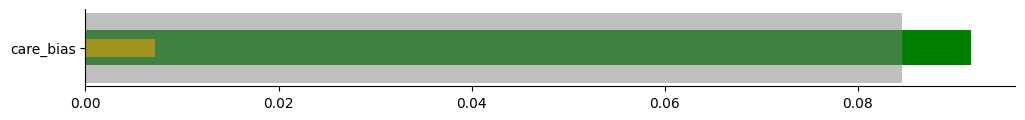
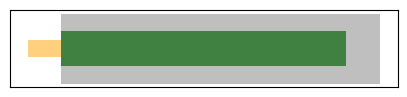
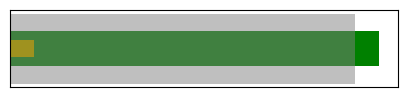
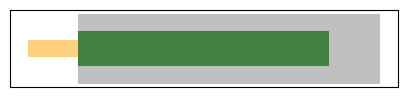
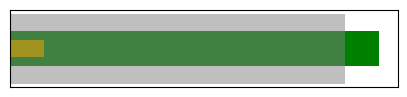
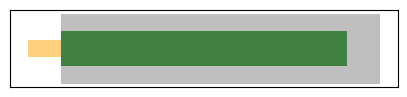
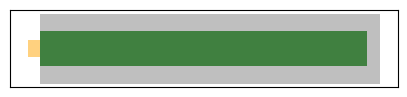
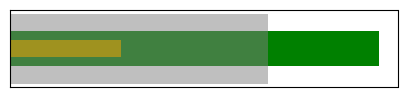
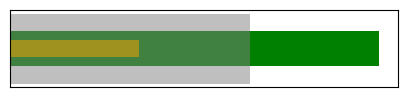
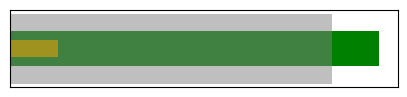
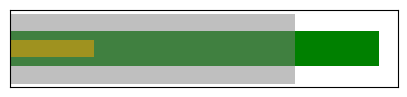

In [ ]:
plot_article_bias_shifts(article_data, class_column_names, df_background_means, 'care_bias', tokenizer)

In [ ]:
category_lists_fx.keys()

dict_keys(['Capacity and Resources', 'Crime and Punishment', 'Cultural Identity', 'Economic', 'External Regulation and Reputation', 'Fairness and Equality', 'Health and Safety', 'Legality, Constitutionality, Jurisdiction', 'Morality', 'Other', 'Policy Prescription and Evaluation', 'Political', 'Public Sentiment', 'Quality of Life', 'Security and Defense'])

In [ ]:
microframe_keys = [
    'authority_bias', 'authority_intensity', 'care_bias', 'care_intensity',
    'fairness_bias', 'fairness_intensity', 'loyalty_bias', 'loyalty_intensity',
    'sanctity_bias', 'sanctity_intensity'
]

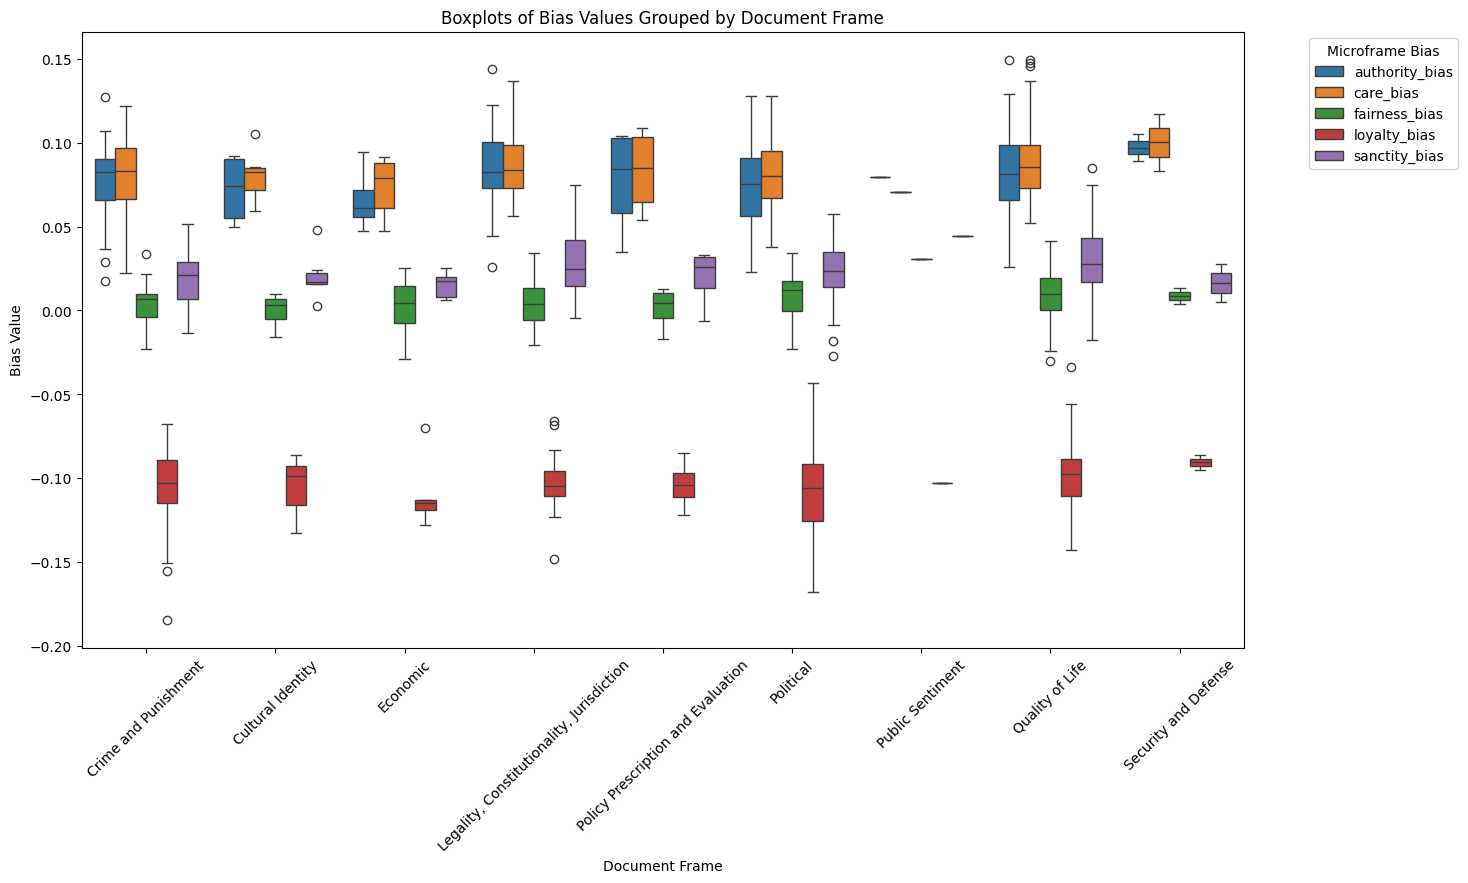

In [ ]:
import matplotlib.pyplot as plt

# Flatten the data into a DataFrame for easier manipulation
data = []

for document_frame, arrays in category_lists_fx.items():
    for arr in arrays:
        data.append([document_frame] + list(arr))

df = pd.DataFrame(data, columns=['document_frame'] + microframe_keys)

# Extracting only bias columns
bias_columns = [col for col in df.columns if 'bias' in col]
bias_df = df[['document_frame'] + bias_columns]

bias_df = bias_df[(bias_df[bias_columns] != 0).any(axis=1)]

# Generate boxplots
plt.figure(figsize=(15, 8))
bias_df_melted = bias_df.melt(id_vars=['document_frame'], var_name='microframe', value_name='value')

# Plotting
import seaborn as sns
sns.boxplot(x='document_frame', y='value', hue='microframe', data=bias_df_melted)
plt.title('Boxplots of Bias Values Grouped by Document Frame')
plt.xlabel('Document Frame')
plt.ylabel('Bias Value')
plt.legend(title='Microframe Bias', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

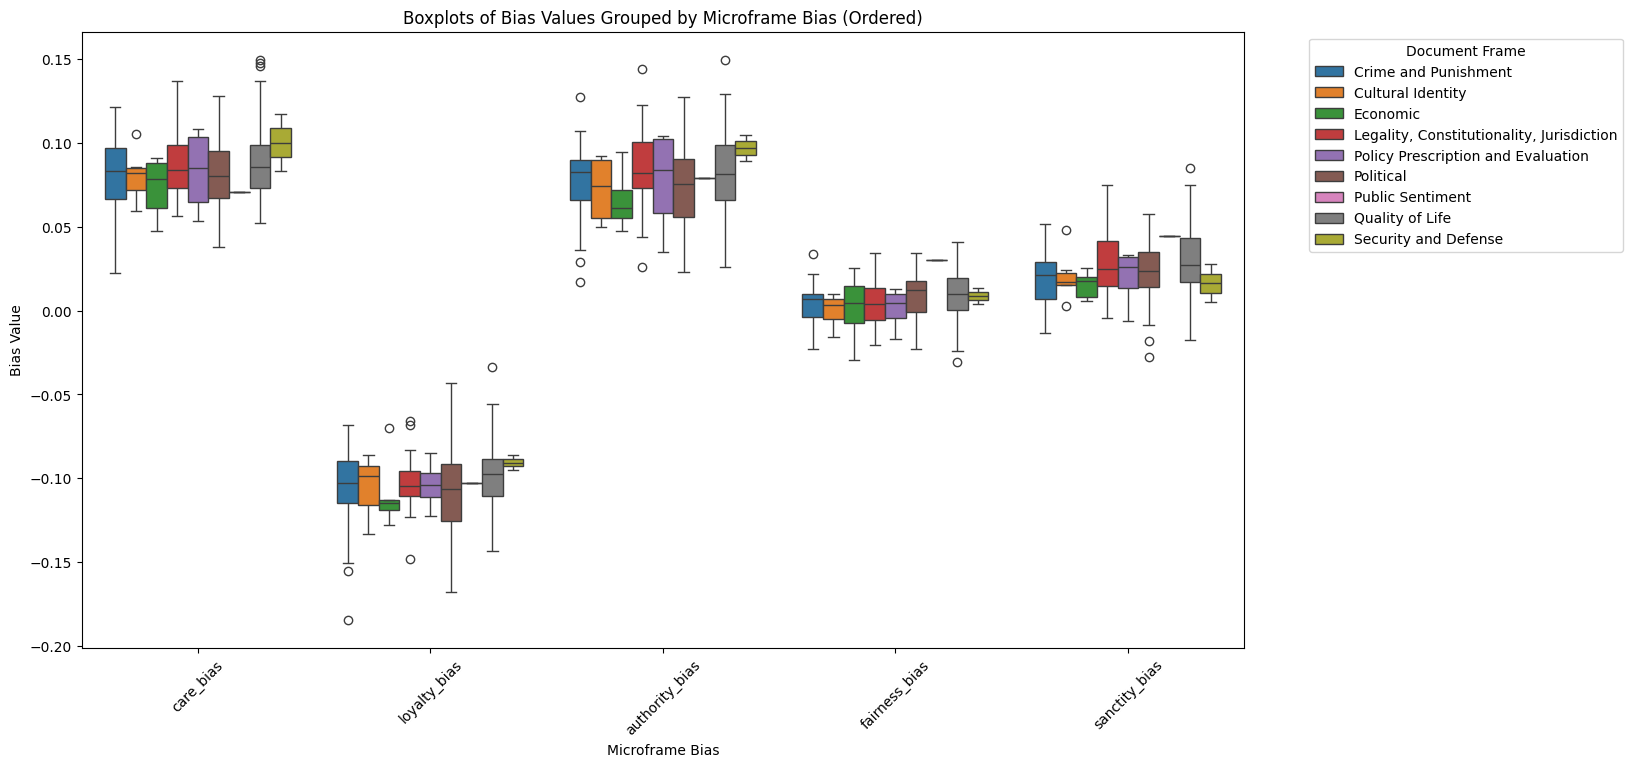

In [ ]:
# Define the desired order for microframe biases
bias_order = ['care_bias', 'loyalty_bias', 'authority_bias', 'fairness_bias', 'sanctity_bias']

# Filter the melted DataFrame to only include these biases and order them accordingly
bias_df_melted_ordered = bias_df_melted[bias_df_melted['microframe'].isin(bias_order)]
bias_df_melted_ordered['microframe'] = pd.Categorical(bias_df_melted_ordered['microframe'], categories=bias_order, ordered=True)

plt.figure(figsize=(15, 8))
sns.boxplot(x='microframe', y='value', hue='document_frame', data=bias_df_melted_ordered)
plt.title('Boxplots of Bias Values Grouped by Microframe Bias (Ordered)')
plt.xlabel('Microframe Bias')
plt.ylabel('Bias Value')
plt.legend(title='Document Frame', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


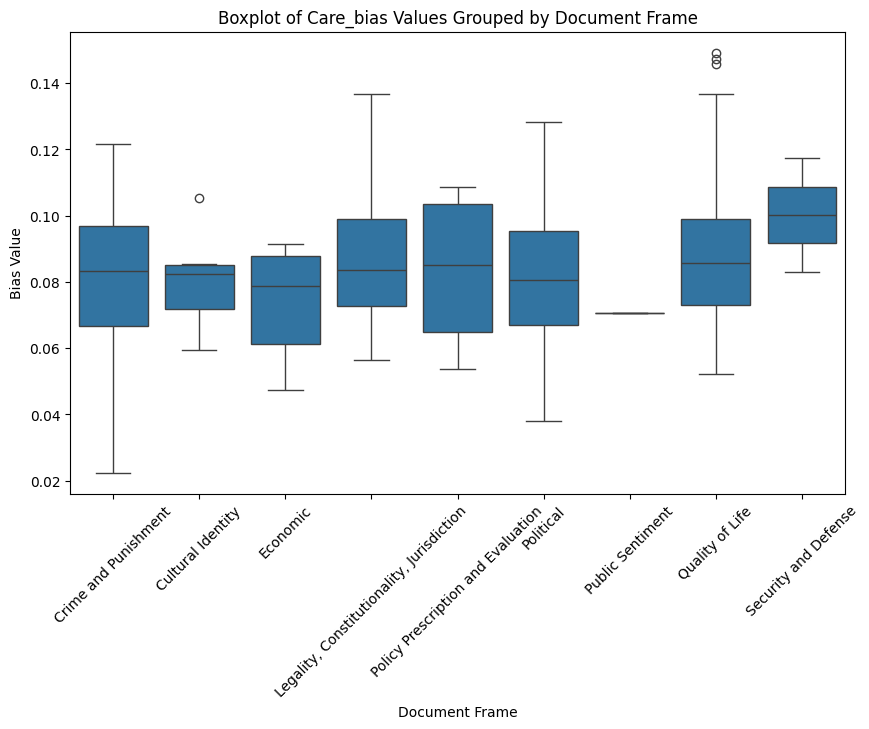

In [ ]:
# Define a function to create the boxplot for a specified microframe bias
def plot_microframe_bias(bias_name):
    filtered_df = bias_df_melted[bias_df_melted['microframe'] == bias_name]

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='document_frame', y='value', data=filtered_df)
    plt.title(f'Boxplot of {bias_name.capitalize()} Values Grouped by Document Frame')
    plt.xlabel('Document Frame')
    plt.ylabel('Bias Value')
    plt.xticks(rotation=45)
    plt.show()

# Plot only for 'care_bias'
plot_microframe_bias('care_bias')
